In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm, expon, beta, uniform, triang, kstest


In [2]:
df_nickel = pd.read_excel(r'data/data_metals_pellan.xlsx', sheet_name='Mudd2014_ni')
df_copper = pd.read_excel(r'data/data_metals_pellan.xlsx', sheet_name='Mudd2018_cop')

Let's explore the distribution of values for ore grade

In [3]:
def plot_grade_statistics(df, grade_column, mineral, country=None):
    # Filter by country if specified
    if country:
        df = df[df['Country'] == country]
    
    # Calculate statistics
    mean_val = df[grade_column].mean()
    min_val = df[grade_column].min()
    max_val = df[grade_column].max()
    std_dev = df[grade_column].std()

    # Create violin plot to show the distribution of values
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df[grade_column], color='skyblue')
    
    # Display min, max, mean, and std as horizontal lines
    plt.axhline(mean_val, color='green', linestyle='--', label=f'Mean: {mean_val:.4f}')
    plt.axhline(min_val, color='blue', linestyle='--', label=f'Min: {min_val:.4f}')
    plt.axhline(max_val, color='red', linestyle='--', label=f'Max: {max_val:.4f}')
    plt.axhline(mean_val + std_dev, color='purple', linestyle=':', label=f'Mean + Std Dev: {(mean_val + std_dev):.4f}')
    plt.axhline(mean_val - std_dev, color='purple', linestyle=':', label=f'Mean - Std Dev: {(mean_val - std_dev):.4f}')
    
    # Add title and labels
    plt.title(f'{mineral} - {grade_column} Distribution' + (f' for {country}' if country else ''))
    plt.xlabel('')
    plt.ylabel(grade_column)
    plt.legend()

    plt.show()
    
    # Return summary statistics in a DataFrame
    summary_df = pd.DataFrame({
        'Mineral': [mineral],
        'Grade Column': [grade_column],
        'Mean': [mean_val],
        'Min': [min_val],
        'Max': [max_val],
        'Std Dev': [std_dev]
    })
    
    return summary_df

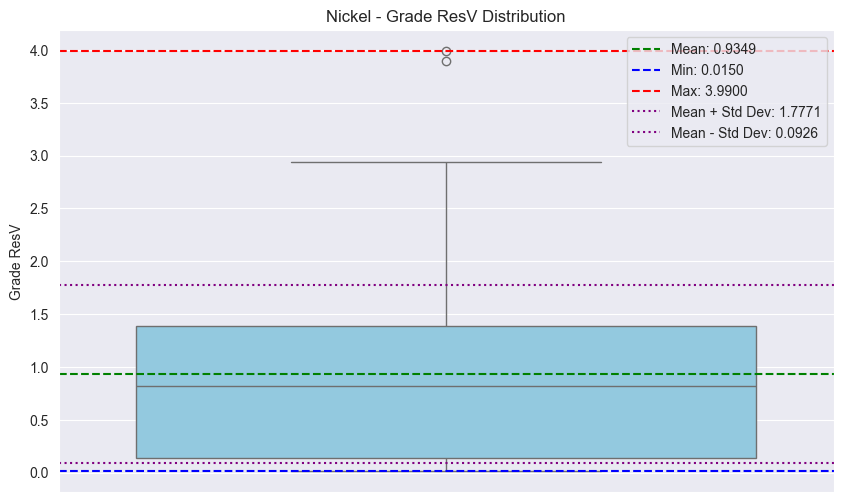

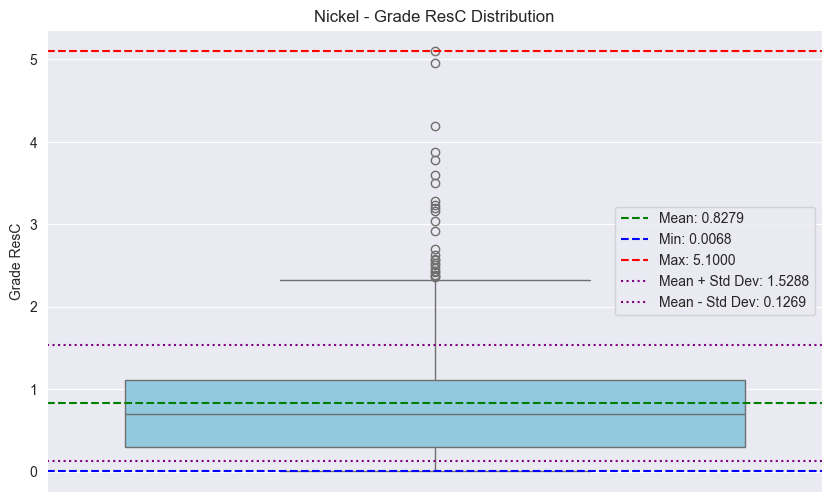

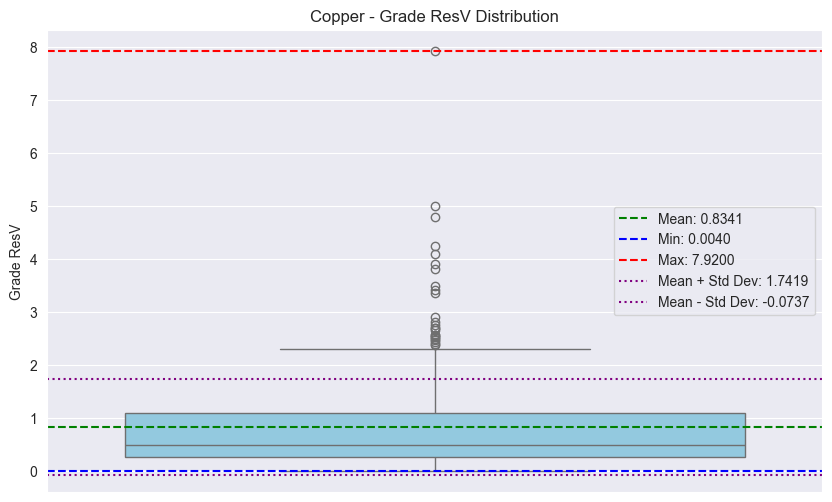

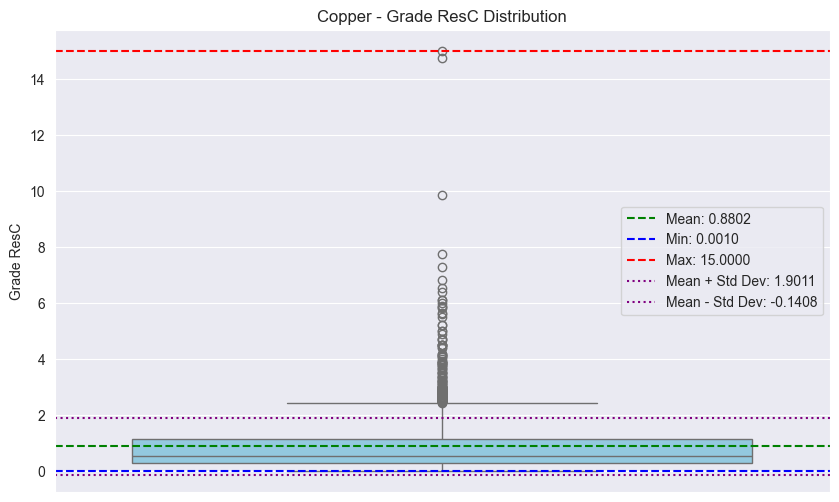

,Mineral,Grade Column,Mean,Min,Max,Std Dev
0,Nickel,Grade ResV,0.934864,0.015000,3.990034,0.842238
1,Nickel,Grade ResC,0.827851,0.006792,5.100000,0.700988
2,Copper,Grade ResV,0.834055,0.004000,7.920000,0.907797
3,Copper,Grade ResC,0.880153,0.001000,15.000000,1.020945


In [4]:
# Using the function for Nickel and Copper grades
nickel_resv = plot_grade_statistics(df_nickel, 'Grade ResV', 'Nickel')
nickel_resc = plot_grade_statistics(df_nickel, 'Grade ResC', 'Nickel')
copper_resv = plot_grade_statistics(df_copper, 'Grade ResV', 'Copper')
copper_resc = plot_grade_statistics(df_copper, 'Grade ResC', 'Copper')

# Concatenate summaries
summary = pd.concat([nickel_resv, nickel_resc, copper_resv, copper_resc], ignore_index=True)

# Display the concatenated summary DataFrame
summary

lca_algebraic supports seven distribution types: 
- Fixed 
- Uniform 
- Triangle
- Normal
- Log-normal
- Beta
- Statistic weight

In [10]:
# Adjust the function to skip beta fitting if data does not meet the requirement
def fit_and_test_distributions(df, grade_column, country=None):
    """
    Fits multiple theoretical distributions to the given ore grade data, 
    visualizes the data with a histogram and overlaid distribution curves, 
    and performs a Kolmogorov-Smirnov (K-S) test to assess the goodness of fit.

    Parameters:
    - df (pd.DataFrame): The dataset containing ore grade data.
    - grade_column (str): The column name for ore grade values.
    - country (str, optional): Specific country to filter the data by. If None, uses all data.

    Returns:
    - results (dict): A dictionary of K-S test results for each distribution, containing:
        - 'Statistic': The maximum difference between the empirical and theoretical cumulative distributions.
        - 'P-value': The probability that the sample data comes from the tested distribution.
        
    Notes:
    - Distributions tested include normal, log-normal, triangular, uniform, and beta (if data is within bounds).
    - Lower statistics and higher p-values indicate a better fit between the data and the tested distribution.
    """
     
    # Filter by country if specified
    if country:
        df = df[df['Country'] == country]
    
    # Drop NaN values and check if data is empty
    data = df[grade_column].dropna()
    if data.empty:
        print(f"No data available for {grade_column} in {country if country else 'all countries'}")
        return None
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=10, density=True, alpha=0.6, color='blue', label="Histogram")

    # Fit and plot normal distribution
    mu, std = norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p_norm = norm.pdf(x, mu, std)
    plt.plot(x, p_norm, 'r-', label="Normal fit")

    # Fit and plot log-normal distribution
    shape, loc, scale = lognorm.fit(data, floc=0)
    p_lognorm = lognorm.pdf(x, shape, loc, scale)
    plt.plot(x, p_lognorm, 'g-', label="Log-normal fit")

    # Fit and plot triangular distribution
    min_val, max_val = data.min(), data.max()
    most_likely = data.mean()  # Typically mean or mode for triangular
    c = (most_likely - min_val) / (max_val - min_val) if max_val != min_val else 0.5
    p_triang = triang.pdf(x, c, loc=min_val, scale=(max_val - min_val))
    plt.plot(x, p_triang, 'b-', label="Triangular fit")

    # Fit and plot uniform distribution
    p_uniform = uniform.pdf(x, loc=min_val, scale=max_val - min_val)
    plt.plot(x, p_uniform, 'm-', label="Uniform fit")

    # Store K-S test results for valid distributions
    results = {
        'Normal': kstest(data, 'norm', args=(mu, std)),
        'Log-normal': kstest(data, 'lognorm', args=(shape, loc, scale)),
        'Triangular': kstest(data, 'triang', args=(c, min_val, max_val - min_val)),
        'Uniform': kstest(data, 'uniform', args=(min_val, max_val - min_val))
    }

    # Attempt Beta fit, skip if data is outside 0-1 range after scaling
    try:
        a, b, loc, scale = beta.fit(data, floc=min_val, fscale=max_val - min_val)
        p_beta = beta.pdf(x, a, b, loc, scale)
        plt.plot(x, p_beta, 'y-', label="Beta fit")
        results['Beta'] = kstest(data, 'beta', args=(a, b, loc, scale))
    except ValueError:
        print(f"Skipping Beta fit for {grade_column} in {country if country else 'all countries'} (data out of bounds)")

    plt.title(f'{grade_column} Distribution Fit' + (f' for {country}' if country else ''))
    plt.xlabel(grade_column)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return results

In [11]:
# Helper function to convert K-S test results into a DataFrame for easier analysis
def extract_results_to_df(results, mineral, grade_column, country=None):
    extracted_data = []
    for dist_name, result in results.items():
        extracted_data.append({
            'Mineral': mineral,
            'Grade Column': grade_column,
            'Country': country if country else 'All',
            'Distribution': dist_name,
            'Statistic': result.statistic,
            'P-value': result.pvalue
        })
    return pd.DataFrame(extracted_data)

Skipping Beta fit for Grade ResV in all countries (data out of bounds)


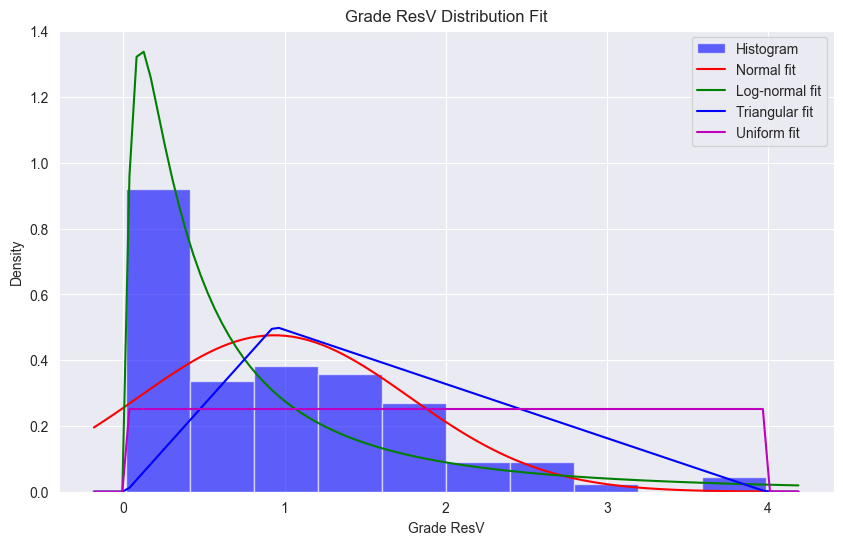

Skipping Beta fit for Grade ResC in all countries (data out of bounds)


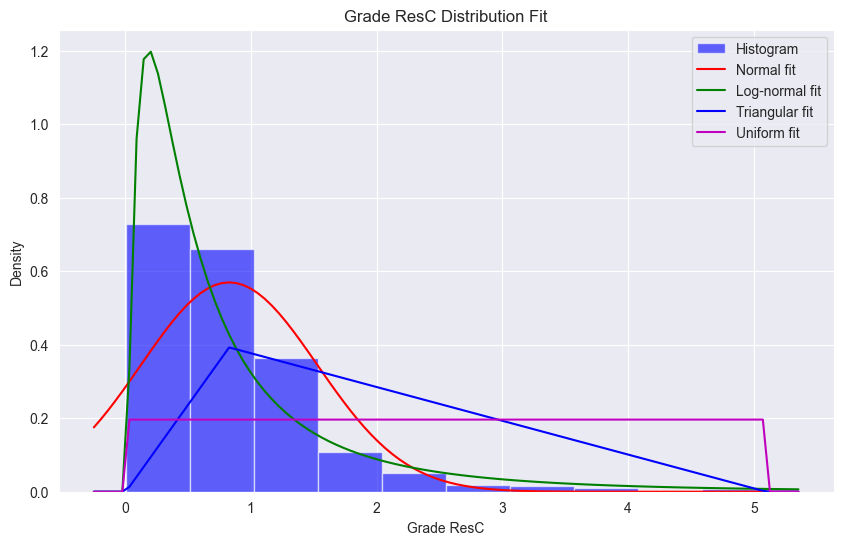

Skipping Beta fit for Grade ResV in all countries (data out of bounds)


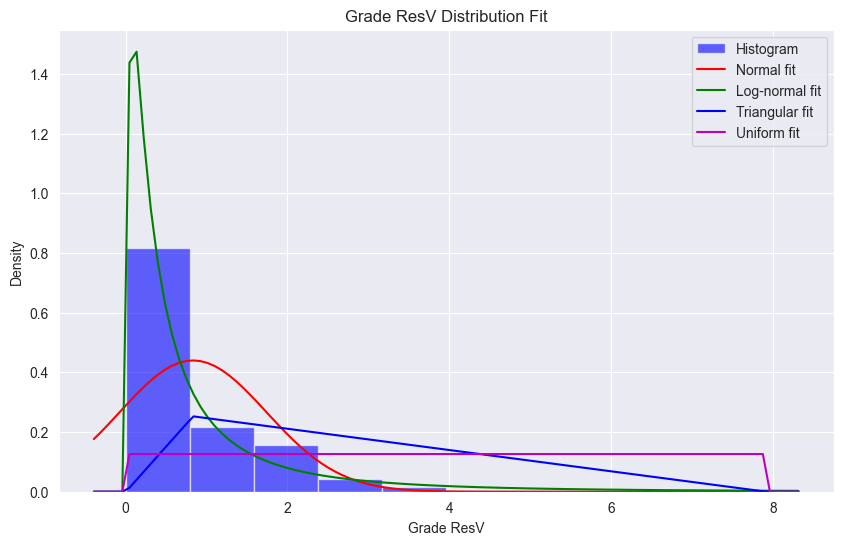

Skipping Beta fit for Grade ResC in all countries (data out of bounds)


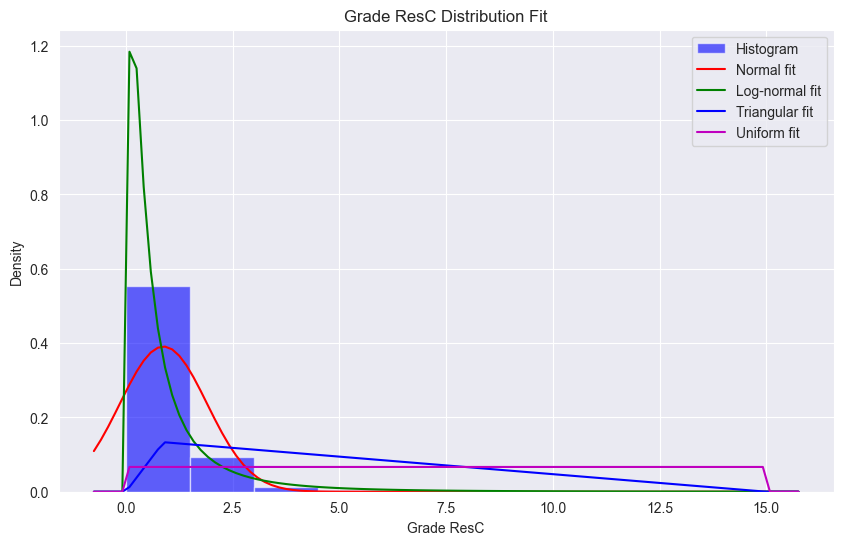

Skipping Beta fit for Grade ResC in Canada (data out of bounds)


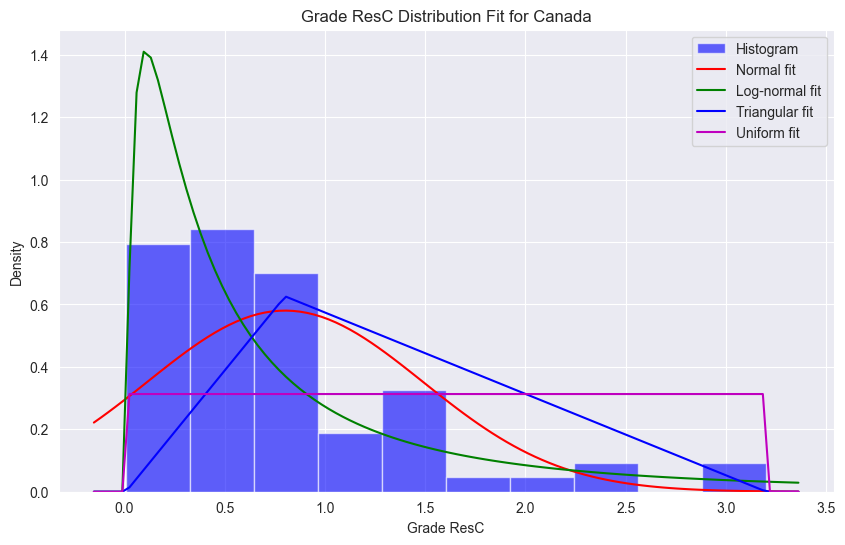

Skipping Beta fit for Grade ResC in Canada (data out of bounds)


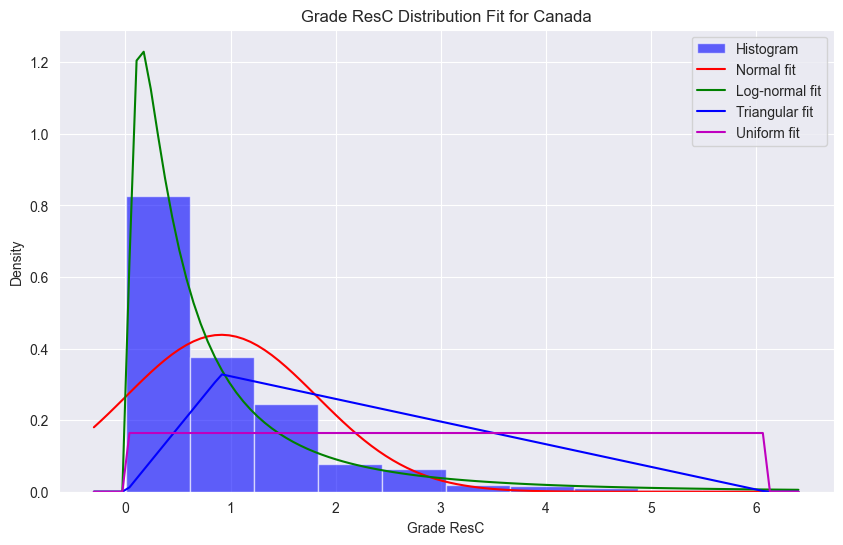

,Mineral,Grade Column,Country,Distribution,Statistic,P-value
0,Nickel,Grade ResV,All,Normal,0.136304,2.818879e-02
1,Nickel,Grade ResV,All,Log-normal,0.159576,5.862025e-03
2,Nickel,Grade ResV,All,Triangular,0.350509,8.313883e-13
3,Nickel,Grade ResV,All,Uniform,0.421113,1.604873e-18
4,Nickel,Grade ResC,All,Normal,0.121163,2.047617e-08
5,Nickel,Grade ResC,All,Log-normal,0.126864,3.472815e-09
6,Nickel,Grade ResC,All,Triangular,0.490494,1.567634e-138
7,Nickel,Grade ResC,All,Uniform,0.596977,3.038197e-212
8,Copper,Grade ResV,All,Normal,0.179968,5.260977e-12
9,Copper,Grade ResV,All,Log-normal,0.098600,6.760557e-04


In [12]:
# Run the new function on Nickel and Copper data
results_nickel_resv = fit_and_test_distributions(df_nickel, 'Grade ResV')
results_nickel_resc = fit_and_test_distributions(df_nickel, 'Grade ResC')
results_copper_resv = fit_and_test_distributions(df_copper, 'Grade ResV')
results_copper_resc = fit_and_test_distributions(df_copper, 'Grade ResC')

# Specific country example, "Canada"
results_nickel_resc_canada = fit_and_test_distributions(df_nickel, 'Grade ResC', country="Canada")
results_copper_resc_canada = fit_and_test_distributions(df_copper, 'Grade ResC', country="Canada")

# Collect all results into DataFrames if results exist
results_dfs = []
if results_nickel_resv: results_dfs.append(extract_results_to_df(results_nickel_resv, 'Nickel', 'Grade ResV'))
if results_nickel_resc: results_dfs.append(extract_results_to_df(results_nickel_resc, 'Nickel', 'Grade ResC'))
if results_copper_resv: results_dfs.append(extract_results_to_df(results_copper_resv, 'Copper', 'Grade ResV'))
if results_copper_resc: results_dfs.append(extract_results_to_df(results_copper_resc, 'Copper', 'Grade ResC'))
if results_nickel_resc_canada: results_dfs.append(extract_results_to_df(results_nickel_resc_canada, 'Nickel', 'Grade ResC', country='Canada'))
if results_copper_resc_canada: results_dfs.append(extract_results_to_df(results_copper_resc_canada, 'Copper', 'Grade ResC', country='Canada'))

# Combine all results into a single DataFrame
df_all_ks_test_results = pd.concat(results_dfs, ignore_index=True)
df_all_ks_test_results 


In [14]:
df_all_ks_test_results.to_excel(r'results/copper_nickel_stat_tests.xlsx')